In [1]:
function fftc(img)
    return ifftshift(fft(fftshift(img)))
end
function ifftc(ksp)
    return fftshift(ifft(ifftshift(ksp)))
end
# adding MAT and PyPlot
Pkg.add("MAT")
Pkg.add("PyPlot")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of MAT
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [3]:
using MAT
# get data from http://hansenms.github.io/sunrise/sunrise2013/
HANSEN = matread("ismrm_sunrise_parallel/hansen_exercises.mat") 

Dict{ASCIIString,Any} with 9 entries:
  "smaps"        => 256x256x8 Array{Complex{Float64},3}:…
  "noise_color"  => 256x256x8 Array{Complex{Float64},3}:…
  "w_spiral"     => 18176x1 Array{Float64,2}:…
  "sp"           => 256x256 Array{Float64,2}:…
  "k_spiral"     => 18176x2 Array{Float64,2}:…
  "data_spiral"  => 18176x8 Array{Complex{Float64},2}:…
  "data"         => 256x256x8 Array{Complex{Float64},3}:…
  "noise_spiral" => 18176x8 Array{Complex{Float64},2}:…
  "reg_img"      => 256x256 Array{Float64,2}:…

In [4]:
# equivalent to locals().update(HANSEN)
for (k, v) in HANSEN
    k=symbol(k) 
    @eval (($k) = ($v))
end

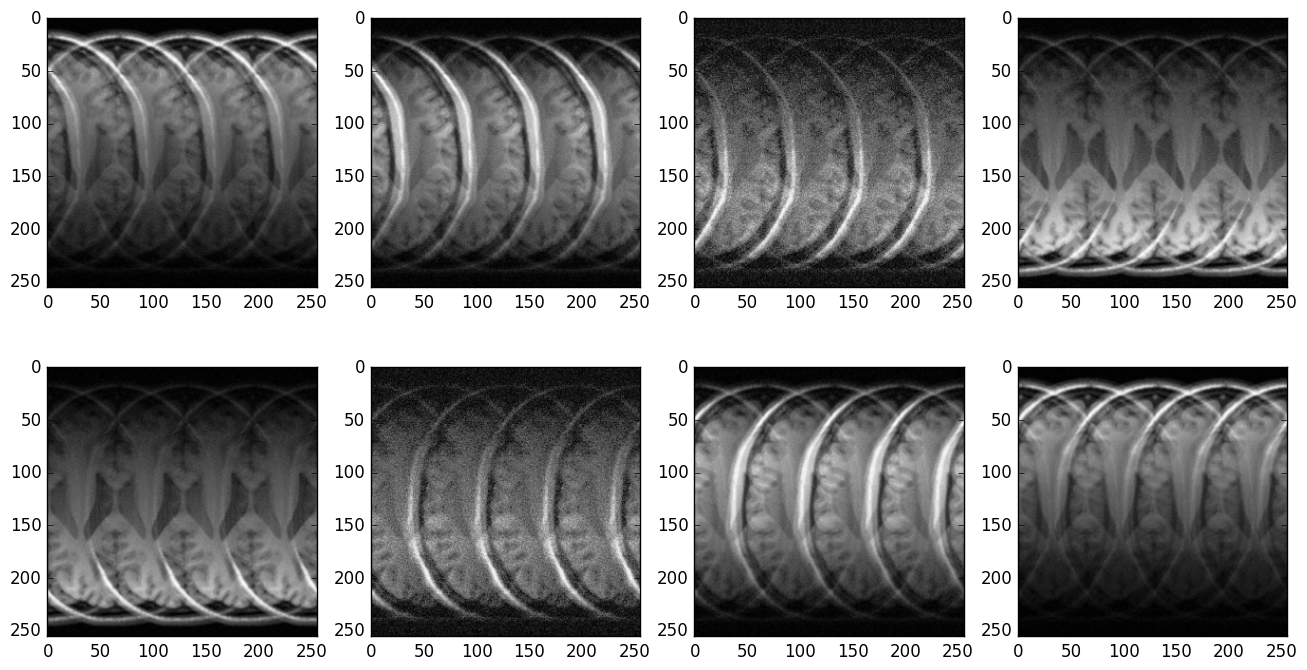

In [5]:
using PyPlot
# Visualize coil images
fig = PyPlot.figure("Coil image", figsize=(16,8))
for i in range(1,4)
    subplot(2, 4, i )
    imshow(abs(ifftc(data[:,:,i+0])), cmap= "Greys_r")
    subplot(2, 4, i + 4)
    imshow(abs(ifftc(data[:,:,i+4])), cmap= "Greys_r")
end

(2000,)

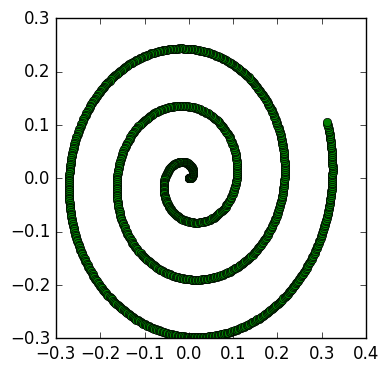

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e06d198>

In [6]:
# Visualize trajectory
figure(figsize=(4,4))
t = k_spiral'[1:1:2000]
# t = reshape(t, 100, 2)
print(size(t))
plot(t[1:2:2000], t[2:2:2000], "go-")

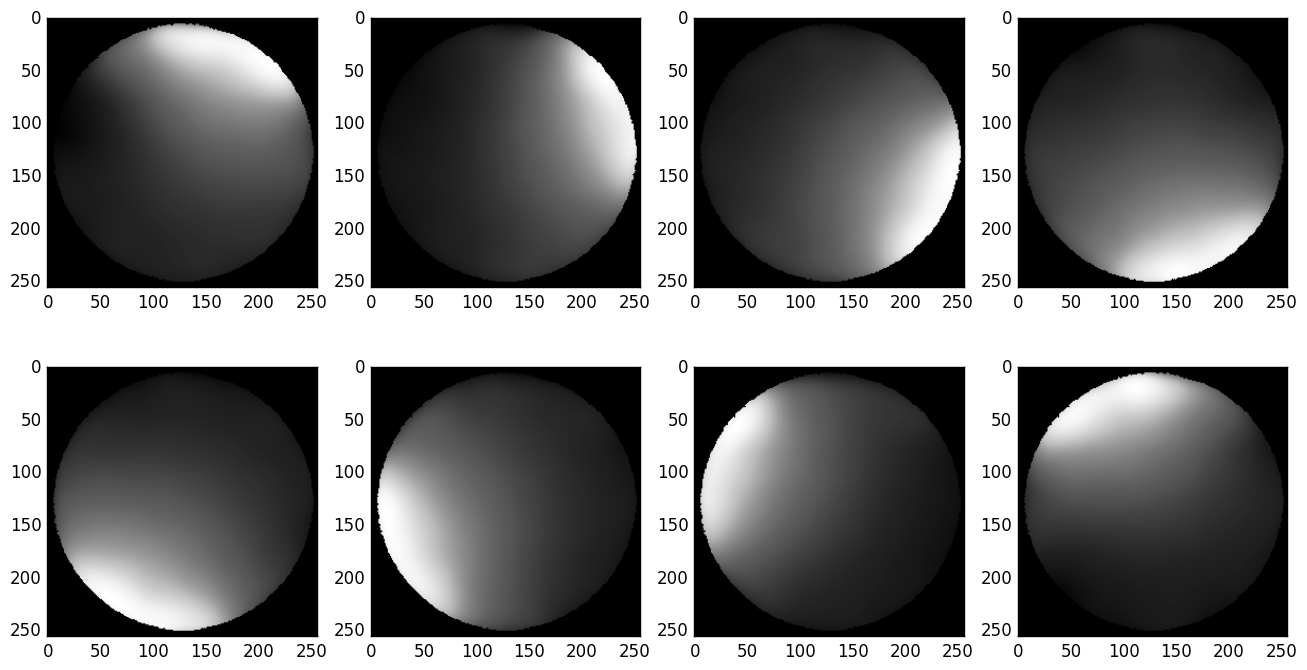

In [7]:
x, y, ncoils = size(smaps)
fig = figure(figsize=(16,8))
for i in range(1, 8)
     subplot(2,4,i) 
    imshow(abs(smaps[:,:,i]), cmap= "Greys_r")
end

In [1]:
function NuFFT(image, coils, k_traj, w, n, osf, wg)
    # padding with zeros 
    pw = pad_width = int( n*(osf-1)/2 )
    image = padarray(image, [pw,pw,0], 0)
    
    # kernel computation 
    kw = wg / osf
    kosf = floor(0.91 / (osf*1e-3))
    kwidth = osf*kw / 2
    beta = pi*sqrt((kw*(osf-0.5))^2-0.8) 
    
    # compute kernel
    om = collect(0:kosf*kwidth)/(kosf*kwidth)
    p = besseli(0, beta*sqrt(1-om.*om))
    p /= p[1]
    p[end] = 0
    
    # deapodize
    x = collect(-osf*n/2:osf*n/2-1)/n
    sqa = sqrt(pi^2*kw^2*x.^2-beta^2)
    dax = sin(sqa)./(sqa)
    # normalize by DC value
    dax = dax/dax(osf*n/2)
    # make it a 2D array
    da = dax*dax' # da dax is recognized as a column vector in julia unlike matlab.
    (l,h) = size(da)
    da = reshape(l,h, 1) # da[:,:,newaxis]
    image = image./da
   (A,B) = size(k_traj)
    m = zeros(A,coils)
    
    # convert k-space trajectory to matrix indices
    nx = n*osf/2 + osf*n*k_traj[:,0]
    ny = n*osf/2 + osf*n*k_traj[:,1]
    
    # Do the NuFFT for each coil
    for j in collect(1:coils)
        kspace = fftc(image[:,:,j])
        # loop over samples in kernel at grid spacing
        for lx in collect(-kwidth:kwidth)
            for ly in collect(-kwidth:kwidth)
                # find nearest samples
                nxt = round(nx+lx)
                nyt = round(ny+ly)
                # seperable kernel value
                kkr = min(round(kosf*sqrt(abs(nx-nxt).^2+abs(ny-nyt).^2)+1), floor(kosf*kwidth)+1)
                kwr = p[kkr]
                
                # if data falls outside matrix, put it at the edge, zero out below
                nxt = max(nxt,1)
                nxt = min(nxt,osf*n)
                nyt = max(nyt,1)
                nyt = min(nyt,osf*n)
                
                for i = 1:length(nxt)
                    vector[i] = kspace[nxt[i],nyt[i]]
                end
                m[:,j] += vector * kwr
            end
        end
    end
    return m.*sqrt(w)
end

NuFFT (generic function with 1 method)